In [1]:
import pickle
from tensorflow.keras.models import load_model
import os
from tensorflow.keras.models import model_from_json
import shap
from sklearn.pipeline import Pipeline
from tensorflow.keras import backend
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import get_session
import lime
from lime import lime_tabular
import numpy as np
from tensorflow.keras import backend
import tensorflow.keras.backend as K
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf
import tensorflow_probability as tfp
import keras
import pandas as pd
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [25]:
with open("test_cfs_binary.pkl", "rb") as f:
    test = pickle.load(f)

In [26]:
test.shape

(99096, 250)

In [27]:
y_test = test["target"]
x_test = test.drop("target", axis=1)
x_test = x_test.drop("PERCENTILE(target)", axis=1)

In [28]:
model_path = "./custom_dnn/"
with open(os.path.join(model_path, "model_sample_dnn2.json"), "r") as file:
    model_json = file.read()
model = model_from_json(model_json)
model.load_weights(os.path.join(model_path, "model_sample_dnn2_100.h5"))

In [29]:
scaler_path = os.path.join(model_path, "scaler_standard_random_fold_0")
with open(scaler_path, "rb") as f:
    scaler = pickle.load(f)
x_test = scaler.transform(x_test)
y_test = y_test.values
x_test = pd.DataFrame(x_test)

Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.


In [30]:
x_test.shape

(99096, 248)

In [32]:
y_pred = model.predict(x_test, verbose = 1, batch_size = 256)

99096/99096 [==============================] - 2s 24us/sample


In [35]:
y_pred

array([[0.01319913],
       [0.24956045],
       [0.02635638],
       ...,
       [0.00564503],
       [0.00407052],
       [0.00596372]], dtype=float32)

In [36]:
error_df = pd.DataFrame({'y_pred':y_pred.reshape(-1),
                        'target':y_test.reshape(-1)})

In [41]:
error_df

,y_pred,target
0,0.013199,0.0
1,0.249560,0.0
2,0.026356,0.0
3,0.011090,0.0
4,0.018239,0.0
...,...,...
99091,0.002941,0.0
99092,0.006866,0.0
99093,0.005645,0.0
99094,0.004071,0.0


In [42]:
error_df = error_df.sample(error_df.shape[0])
error_df = error_df.reset_index(drop=True)

In [50]:
def print_confusion_matrix(ytest, ypred, cut_off):
    """confusion_matrix 출력 format
    
    Arguments:
        ytest {numpy array} -- label 1 or 0
        ypred {numpy array} -- predicted score 0~1
        cut_off {int} -- cut off score
    """
    tp,fn,fp,tn = confusion_matrix(ytest,
                     ypred>cut_off,
                    labels=[1,0]).ravel()
    print(format('cut off :','15s'), format(cut_off,'<15.2f'))
    print("""    {}{}{}
    {}{}{}
    {}{}{}
    """.format(format('Predict \\ True','15s'),format(1,'10.0f'),format(0,'10.0f'),
              format('1','>15s'), format(tp,'10.0f'), format(fp,'10.0f'),
               format('0','>15s'), format(fn,'10.0f'), format(tn,'10.0f')
              ))
    recall = tp/(tp+fn)*100 if (tp+fn) != 0 else 0
    precision = tp/(tp+fp)*100 if (tp+fp) != 0 else 0
    print(format('recall :','15s'),format(recall, '<15.3f'))
    print(format('precision :','15s'),format(precision, '<15.3f'))
    print(format('f1_score :','15s'),format(2*tp/(2*tp+fp+fn)*100, '<15.3f'))

In [54]:
print_confusion_matrix(error_df.target, error_df.y_pred, cut_off=0.5)

cut off :       0.50           
    Predict \ True          1         0
                  1       845       269
                  0       160     97822
    
recall :        84.080         
precision :     75.853         
f1_score :      79.755         


In [61]:
import matplotlib.pyplot as plt
def visualize_anomaly(error_df, threshold = None):
    """anomaly graph 출력
    
    Arguments:
        error_df {pandas DataFrame} -- target, y_pred column이 포함된 DataFrame
                clss : label
                y_pred : 예측된 스코어
    
    Keyword Arguments:
        threshold {int} -- 그래프에 출력될 cut off값, 미지정시 상위 50% 자동  (default: {None})
    """
    if threshold is None:
        threshold = error_df[error_df['target'] == 1].y_pred.quantile(q = 0.5) # 95 % higher
        print('Generated threshold : {}'.format(threshold))
    else:
        print('threshold : {}'.format(threshold))
    fig, ax = plt.subplots(figsize = (10,6))

    for name, group in error_df.groupby('target'):
        ax.plot(group.index, group['y_pred'], marker = 'o', linestyle = '', alpha = 0.6, 
                label = "Fraud" if name == 1 else "Normal",
                color = 'r' if name == 1 else 'royalblue')

    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], 
              colors = 'r', zorder = 100, label = 'Threshold')
    ax.legend()

Generated threshold : 0.9988174080848694


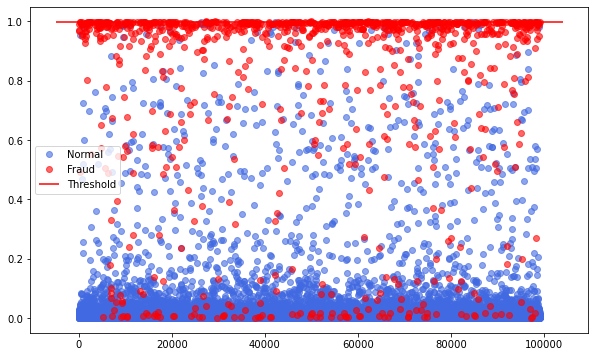

In [62]:
visualize_anomaly(error_df)

# LIME

In [14]:
col_list = test.drop(["target", "PERCENTILE(target)"], axis=1).columns.tolist()

In [65]:
cate = ["AGRT_ORGN_ROLE_SE_CD_C","ENPR_CRDT_BAD_YN_N"]

In [19]:
import pandas as pd
x_test = pd.DataFrame(x_test)

In [191]:
x_test.columns.tolist = col_list

In [124]:
x_test.head()

,MEAN(data.PERCENTILE(이체권한_보유자_숫자)),BSTP_NM_Y_2,SPLR_BUCDT_NM_3,MAX(data.PERCENTILE(이체권한_보유자_숫자)),ENPR_SCL_CD_2,AGRT_ORGN_ROLE_SE_CD_D,ORGN_CL_CD_SG5008,EXCT_KIND_SE_CD_B03001,PERCENT_TRUE(data.기관통합관리책임자_보유_여부_Y),DPTC_ITEPD_CD_B0202049,...,PERCENTILE(USE_SPLY_AMT_log),HIRK_BSNS_CL_CD_B10055,정밀점검대상여부_Y,PERCENTILE(FPU_SUM_AMT),ORGN_CL_CD_SG5020,PERCENT_TRUE(data.orgn.AGRT_ORGN_ENPR_SCL_CD_5.0),MIN(data.BSNS_NM_2),ENPR_FORM_NM_0,AGRT_ORGN_ROLE_SE_CD_C,ENPR_CRDT_BAD_YN_N
5,0.035276,0.125003,0.625,0.035276,1.0,1.0,1.0,0.0,0.0,0.0,...,0.855629,0.0,0.0,0.846781,0.0,0.0,0.083381,0.130741,0.0,1.0
9,0.500001,0.125003,0.625,0.500001,1.0,1.0,1.0,0.0,0.0,0.0,...,0.855656,0.0,0.0,0.846801,0.0,0.0,0.190239,0.130740,0.0,1.0
19,0.466137,0.125001,0.625,0.466137,1.0,0.0,0.0,0.0,0.0,0.0,...,0.941732,0.0,0.0,0.934856,1.0,0.0,0.083381,0.130776,0.0,1.0
21,0.466137,0.125001,0.625,0.466137,1.0,0.0,0.0,1.0,0.0,0.0,...,0.836192,0.0,0.0,0.827359,1.0,0.0,0.083381,0.130791,0.0,1.0
25,0.383571,0.125001,0.625,0.383571,1.0,0.0,0.0,0.0,0.0,0.0,...,0.930620,0.0,0.0,0.923426,1.0,0.0,0.083381,0.130777,0.0,1.0


In [20]:
x_test.columns = col_list

In [1]:
x_test.head()

NameError: name 'x_test' is not defined

In [21]:
x_test.reset_index(inplace=True)

In [22]:
x_test.drop("index", axis=1, inplace=True)

In [89]:
np.array(x_test).shape

(99096, 248)

In [147]:
np.array(x_test)[0,:].shape

(248,)

In [153]:
x_test.iloc[0,:]

0     -1.532677
1     -0.146944
2      0.564254
3     -1.532677
4      0.352118
         ...   
243   -0.770705
244   -0.815541
245    0.264707
246   -1.009249
247    0.173383
Name: 0, Length: 248, dtype: float64

In [149]:
explainer = lime_tabular.LimeTabularExplainer(np.array(x_test)[0], mode='classification', feature_names=col_list, class_names=["target"], verbose = True, random_state = 42)

IndexError: tuple index out of range

In [135]:
x_test.loc[1]

MEAN(data.PERCENTILE(이체권한_보유자_숫자))                   0.500001
BSTP_NM_Y_2                                          0.125003
SPLR_BUCDT_NM_3                                      0.625000
MAX(data.PERCENTILE(이체권한_보유자_숫자))                    0.500001
ENPR_SCL_CD_2                                        1.000000
                                                       ...   
PERCENT_TRUE(data.orgn.AGRT_ORGN_ENPR_SCL_CD_5.0)    0.000000
MIN(data.BSNS_NM_2)                                  0.190239
ENPR_FORM_NM_0                                       0.130740
AGRT_ORGN_ROLE_SE_CD_C                               0.000000
ENPR_CRDT_BAD_YN_N                                   1.000000
Name: 1, Length: 248, dtype: float64

In [139]:
def predict(inputs):
#     print(inputs.shape)
#     inputs = inputs.reshape(1, -1)
#     print(inputs.shape)
    pred = model.predict(inputs).reshape(-1)
    return np.array(list(zip(pred, 1-pred)))

In [140]:
predict(x_test[0].reshape(1,-1))

(248,)
(1, 248)


array([[0.01319912, 0.9868009 ]], dtype=float32)

In [98]:
x_test.head()

,0,1,2,3,4,5,6,7,8,9,...,238,239,240,241,242,243,244,245,246,247
0,-1.532677,-0.146944,0.564254,-1.532677,0.352118,2.116020,1.363896,-0.525965,-0.510265,-0.173256,...,1.150644,-0.117042,-0.131644,1.120576,-0.217320,-0.770705,-0.815541,0.264707,-1.009249,0.173383
1,0.325940,-0.146944,0.564254,0.325940,0.352118,2.116020,1.363896,-0.525965,-0.510265,-0.173256,...,1.150740,-0.117042,-0.131644,1.120647,-0.217320,-0.770705,0.031216,0.264625,-1.009249,0.173383
2,0.190502,-0.146989,0.564254,0.190502,0.352118,-0.506237,-0.761236,-0.525965,-0.510265,-0.173256,...,1.452727,-0.117042,-0.131644,1.429593,4.748215,-0.770705,-0.815541,0.268135,-1.009249,0.173383
3,0.190502,-0.146989,0.564254,0.190502,0.352118,-0.506237,-0.761236,2.033370,-0.510265,-0.173256,...,1.082451,-0.117042,-0.131644,1.052432,4.748215,-0.770705,-0.815541,0.269618,-1.009249,0.173383
4,-0.139710,-0.146989,0.564254,-0.139710,0.352118,-0.506237,-0.761236,-0.525965,-0.510265,-0.173256,...,1.413742,-0.117042,-0.131644,1.389491,4.748215,-0.770705,-0.815541,0.268287,-1.009249,0.173383


In [ ]:
# 사고 데이터 index
np.where(y_test == 1)

In [ ]:
# 위 실행하고 아래 index 골라서 확인
idx = 

In [104]:
x_test.loc[1].values.shape

(248,)

In [141]:
tmp_x = x_test.iloc[0].values
tmp_x.shape

(248,)

In [142]:
expm = explainer.explain_instance(data[idx], predict)
expm.show_in_notebook(show_table = True)

(5000, 248)
(1, 1240000)


ValueError: Error when checking input: expected input_1 to have shape (248,) but got array with shape (1240000,)

In [17]:
lime_tabular.LimeTabularExplainer?